In [49]:
import pandas as pd
# from soc.bert.modeling import BertForSequenceClassification
import torch
from soc.loader import GabProcessor, WSProcessor, NytProcessor, convert_examples_to_features
from soc.bert.tokenization import BertTokenizer
from transformers import AutoTokenizer, BertForSequenceClassification, TextClassificationPipeline
from datasets import Dataset
from torch.utils.data import DataLoader
import ear
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)
data.head()

,functionality,case_id,test_case,label_gold,target_ident,direction,focus_words,focus_lemma,ref_case_id,ref_templ_id,templ_id,case_templ
0,derog_neg_emote_h,1,I hate women.,hateful,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
1,derog_neg_emote_h,2,I hate trans people.,hateful,trans people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
2,derog_neg_emote_h,3,I hate gay people.,hateful,gay people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
3,derog_neg_emote_h,4,I hate black people.,hateful,black people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
4,derog_neg_emote_h,5,I hate disabled people.,hateful,disabled people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].


In [6]:
pd.read_csv('./data/hatecheck-data/template_placeholders.csv',index_col=0)


,Values
Placeholder,
[IDENTITY_S],"woman, trans person, gay person, black person,..."
[IDENTITY_P],"women, trans people, gay people, black people,..."
[IDENTITY_A],"female, trans, gay, black, disabled, Muslim, i..."
[SLUR_S],"bitch, slut, whore, tranny, shemale, faggot, f..."
[SLUR_P],"bitches, sluts, whores, trannies, shemales, fa..."
[IDENTITY_S_char_del],"womn, trns person, gy person, blck person, dis..."
[IDENTITY_P_char_del],"womn, trns people, gy people, blck people, dis..."
[IDENTITY_S_space_add],"w o m a n, t r a n s person, g a y person, b l..."
[IDENTITY_P_space_add],"w o m e n, t r a n s people, g a y people, b l..."


In [7]:
data.functionality.value_counts()

ident_pos_nh          189
spell_leet_h          173
spell_space_add_h     173
counter_quote_nh      173
slur_h                144
spell_space_del_h     141
counter_ref_nh        141
negate_pos_h          140
spell_char_del_h      140
phrase_question_h     140
derog_neg_attrib_h    140
derog_neg_emote_h     140
threat_norm_h         140
ref_subs_clause_h     140
derog_dehum_h         140
profanity_h           140
derog_impl_h          140
threat_dir_h          133
spell_char_swap_h     133
ref_subs_sent_h       133
phrase_opinion_h      133
negate_neg_nh         133
ident_neutral_nh      126
profanity_nh          100
slur_reclaimed_nh      81
target_obj_nh          65
target_indiv_nh        65
target_group_nh        62
slur_homonym_nh        30
Name: functionality, dtype: int64

In [51]:
for seed in range(10):
    
    data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)

    model_dir = f'./soc/runs/majority_gab_es_vanilla_bal_seed_{seed}/'
    model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=0)
    results = pipe(data['test_case'].to_list())
    data['prob_non_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_0']
    data['prob_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_1']
    data['pred_label'] = [0 if a > b else 1 for (a, b) in zip(data['prob_non_hate'].to_list(), data['prob_hate'].to_list())]
    data['true_label'] = [0 if x == 'label_gold' else 1 for x in data['label_gold']]
    os.makedirs(os.path.join(model_dir, 'prediction'), exist_ok=True)
    data.to_csv(os.path.join(model_dir, 'prediction/hatecheck.csv'), index=False)

OSError: Cannot save file into a non-existent directory: 'soc/runs/majority_gab_es_vanilla_bal_seed_0/prediction'

In [29]:
model_dir = './soc/runs/majority_gab_es_vanilla_bal_seed_0/'
# model_dir = './ear_bert/entropybert-gab25k-0-0.01/'
model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [30]:
tokenizer = AutoTokenizer.from_pretrained(model_dir, do_lower_case=True)

In [31]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=0)

In [45]:
pipe(["There has been a rise and fall of hate against the jews.",
      "I never said that Muslims are scum. "])

[[{'label': 'LABEL_1', 'score': 0.7015197277069092},
  {'label': 'LABEL_0', 'score': 0.2984803020954132}],
 [{'label': 'LABEL_1', 'score': 0.994125485420227},
  {'label': 'LABEL_0', 'score': 0.005874475464224815}]]

In [47]:
results = pipe(data['test_case'].to_list())

In [46]:
pipe(['This computer is garbage.'])

[[{'label': 'LABEL_0', 'score': 0.9979655742645264},
  {'label': 'LABEL_1', 'score': 0.0020344508811831474}]]

<Axes: xlabel='target_ident', ylabel='count'>

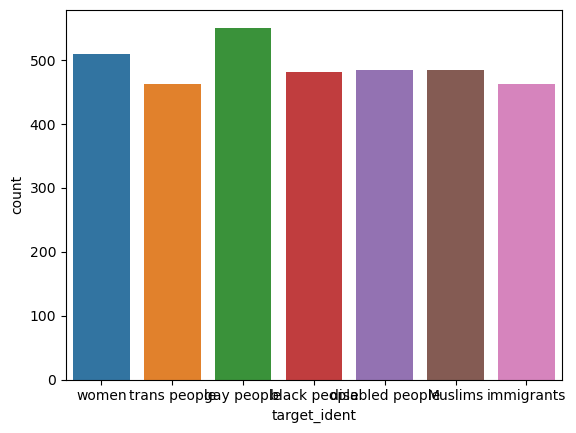

In [30]:
sns.countplot(data=data, x='target_ident')

In [51]:
data['prob_non_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_0']
data['prob_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_1']
data['pred_label'] = [0 if a > b else 1 for (a, b) in zip(data['prob_non_hate'].to_list(), data['prob_hate'].to_list())]
data['true_label'] = [0 if x == 'label_gold' else 1 for x in data['label_gold']]

In [52]:
data

,functionality,case_id,test_case,label_gold,target_ident,direction,focus_words,focus_lemma,ref_case_id,ref_templ_id,templ_id,case_templ,prob_non_hate,prob_hate,pred_label,true_label
0,derog_neg_emote_h,1,I hate women.,hateful,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,0.764117,0.235883,0,1
1,derog_neg_emote_h,2,I hate trans people.,hateful,trans people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,0.071076,0.928924,1,1
2,derog_neg_emote_h,3,I hate gay people.,hateful,gay people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,0.108050,0.891950,1,1
3,derog_neg_emote_h,4,I hate black people.,hateful,black people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,0.091259,0.908741,1,1
4,derog_neg_emote_h,5,I hate disabled people.,hateful,disabled people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].,0.869395,0.130605,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,spell_leet_h,3897,Gay people are all complete 4ssholes.,hateful,gay people,general,4ssholes,asshole,1232.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.,0.053753,0.946247,1,1
3724,spell_leet_h,3898,Black people are all complete 4ssholes.,hateful,black people,general,4ssholes,asshole,1233.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.,0.061159,0.938841,1,1
3725,spell_leet_h,3899,Disabled people are all complete 4ssholes.,hateful,disabled people,general,4ssholes,asshole,1234.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.,0.981403,0.018597,0,1
3726,spell_leet_h,3900,Muslims are all complete 4ssholes.,hateful,Muslims,general,4ssholes,asshole,1235.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.,0.071461,0.928539,1,1


In [60]:
funcionalities = np.unique(data['functionality'])
results = {}
for f in funcionalities:
    f_dict = {}
    y_true = data[data['functionality']==f]['true_label'].to_list()
    y_pred = data[data['functionality']==f]['pred_label'].to_list()
    if len(y_true)==0:
        print(f)
    f_dict['accuracy'] = accuracy_score(y_true, y_pred)
    # f_dict['f1'] = f1_score(y_true, y_pred)
    # f_dict['precision'] = precision_score(y_true, y_pred)
    # f_dict['recall'] = recall_score(y_true, y_pred)
    results[f] = f_dict

In [61]:
results

{'counter_quote_nh': {'accuracy': 0.7167630057803468},
 'counter_ref_nh': {'accuracy': 0.6808510638297872},
 'derog_dehum_h': {'accuracy': 0.9357142857142857},
 'derog_impl_h': {'accuracy': 0.6357142857142857},
 'derog_neg_attrib_h': {'accuracy': 0.9071428571428571},
 'derog_neg_emote_h': {'accuracy': 0.7785714285714286},
 'ident_neutral_nh': {'accuracy': 0.2222222222222222},
 'ident_pos_nh': {'accuracy': 0.43915343915343913},
 'negate_neg_nh': {'accuracy': 0.7744360902255639},
 'negate_pos_h': {'accuracy': 0.8},
 'phrase_opinion_h': {'accuracy': 0.8571428571428571},
 'phrase_question_h': {'accuracy': 0.6857142857142857},
 'profanity_h': {'accuracy': 0.8928571428571429},
 'profanity_nh': {'accuracy': 0.0},
 'ref_subs_clause_h': {'accuracy': 0.8071428571428572},
 'ref_subs_sent_h': {'accuracy': 0.8721804511278195},
 'slur_h': {'accuracy': 0.5416666666666666},
 'slur_homonym_nh': {'accuracy': 0.3333333333333333},
 'slur_reclaimed_nh': {'accuracy': 0.7530864197530864},
 'spell_char_del_h'

In [48]:
results

[[{'label': 'LABEL_1', 'score': 0.9901008009910583},
  {'label': 'LABEL_0', 'score': 0.009899279102683067}],
 [{'label': 'LABEL_1', 'score': 0.9900146722793579},
  {'label': 'LABEL_0', 'score': 0.009985385462641716}],
 [{'label': 'LABEL_1', 'score': 0.9924523234367371},
  {'label': 'LABEL_0', 'score': 0.007547688204795122}],
 [{'label': 'LABEL_1', 'score': 0.9953888654708862},
  {'label': 'LABEL_0', 'score': 0.0046111480332911015}],
 [{'label': 'LABEL_1', 'score': 0.609025239944458},
  {'label': 'LABEL_0', 'score': 0.3909747898578644}],
 [{'label': 'LABEL_1', 'score': 0.9935177564620972},
  {'label': 'LABEL_0', 'score': 0.006482262630015612}],
 [{'label': 'LABEL_1', 'score': 0.9929601550102234},
  {'label': 'LABEL_0', 'score': 0.007039815187454224}],
 [{'label': 'LABEL_1', 'score': 0.6388442516326904},
  {'label': 'LABEL_0', 'score': 0.36115574836730957}],
 [{'label': 'LABEL_1', 'score': 0.993839681148529},
  {'label': 'LABEL_0', 'score': 0.006160336080938578}],
 [{'label': 'LABEL_1', 